## Clay Minerals

### 1. Data Analysis

In [322]:
import datetime as dt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [323]:
def removeNoize(x: float, 
                acid: str,
                element: str,
               df_control: pd.DataFrame)-> float:
    """
    remove background values for each acid
    
    x: float - value in mmol/l without correction
    acid: str - kind of acid 
    element: str - element to correct
    df_control: pd.DataFrame - df with values for acids
    
    return float: corrected value
    """
    
    mask = df_control['parameter']==acid
    select = df_control.loc[mask, element]
    if len(select) == 0:
        print(acid, element)
    return x - select.values[0]

In [324]:
# use science style 
plt.style.use(['science', 'no-latex'])

sns.set_palette('colorblind')
plt.rcParams.update({'font.size':16})

In [325]:
# start = dt.datetime(year=2022, month=1, day=26)
# end = dt.datetime(year=2022, month=3, day=21)
# delta = 107 + 54

In [326]:
df = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ICP')

dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['parameter', 'days', 'kind', 'code', 
        'Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
df = df[cols]


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, key]/value
    
mask = df['kind']=='control'
df_control = df.loc[mask].copy()
df = df.loc[~mask].copy()
df = df.reset_index(drop=True)


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, ['parameter', key]].apply(lambda x: removeNoize(x[key], 
                                                                         x['parameter'], 
                                                                         element=key,
                                                                     df_control=df_control), axis=1)

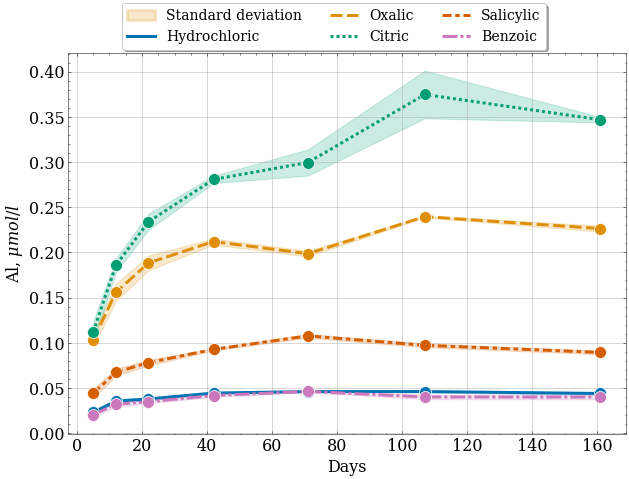

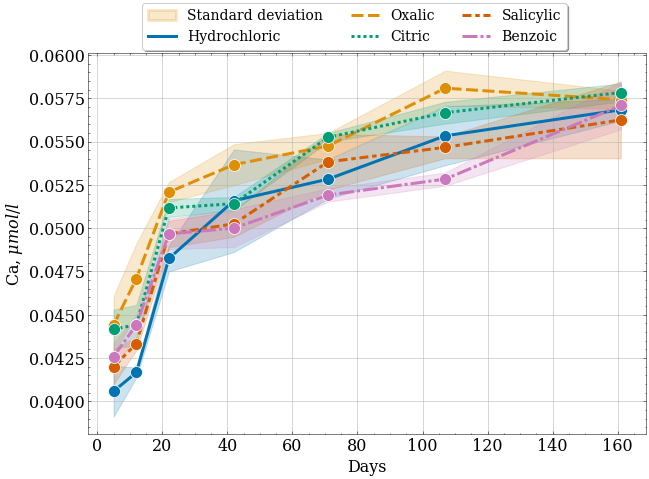

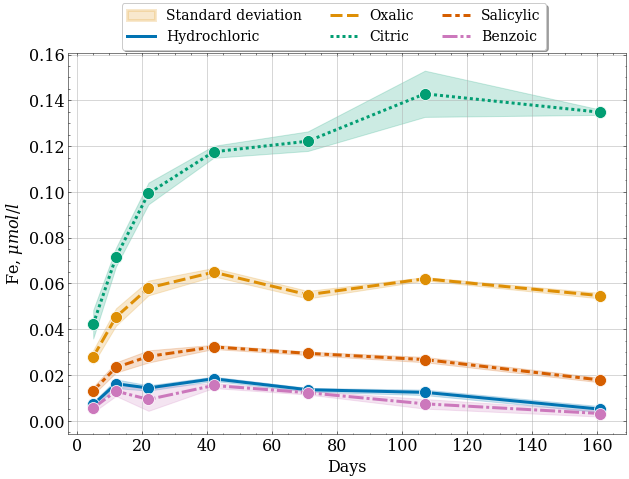

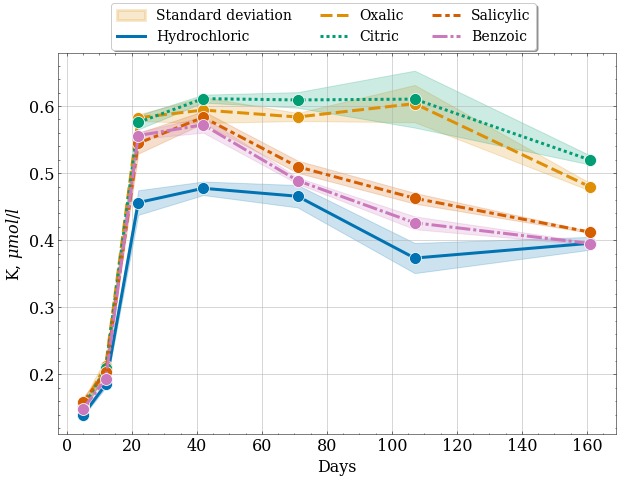

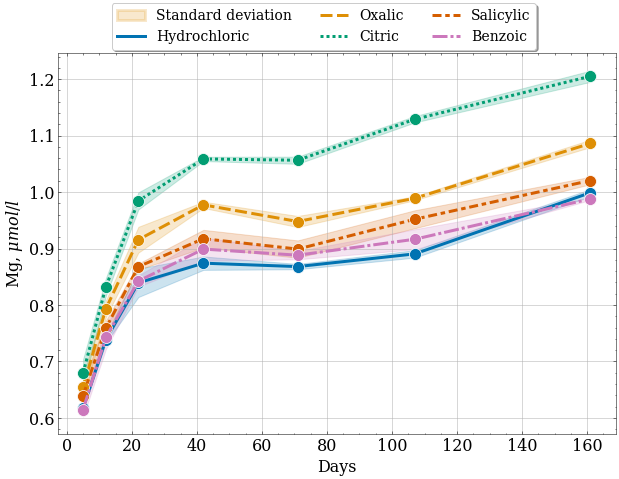

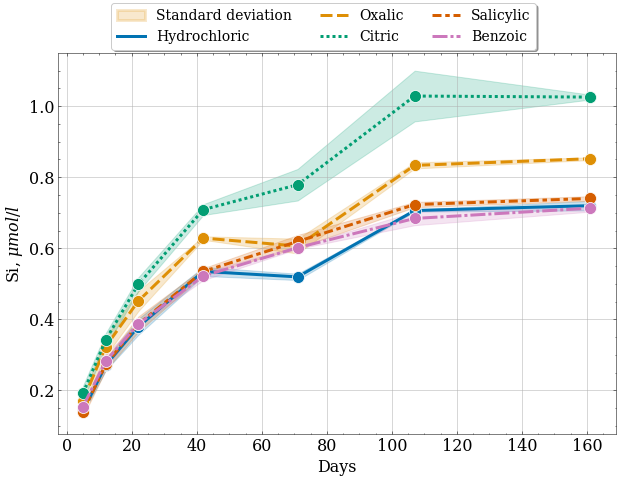

In [327]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
folder = '../plots/acids_elements/'
elements=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
for i, element in enumerate(elements):
    
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=element,
                 marker='o',
                 markersize=12, 
                 data=df, 
                 ci='sd',
#                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'parameter', 
                 linewidth = 3,
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('Standard deviation')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.87, 1.15),
               fontsize=14,  
               ncol=3,
               shadow=True,)
    
#     leg = ax.legend()
    ax.set_ylabel(element+', ${\mu}mol/l$')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(3)
    fname = os.path.join(folder, element+'.png')
#     plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [328]:
df_melted = pd.melt(df, id_vars= ['parameter', 'days', 'kind'],
        value_vars=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si'])

In [331]:
mask = df_melted['days']==161
bar_df = df_melted.loc[mask]

In [433]:
df_melted.to_csv('../data/dataset.csv')

<AxesSubplot:xlabel='value', ylabel='Density'>

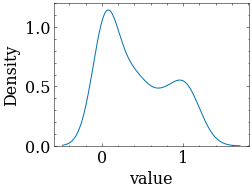

In [369]:
sns.kdeplot(bar_df['value'])

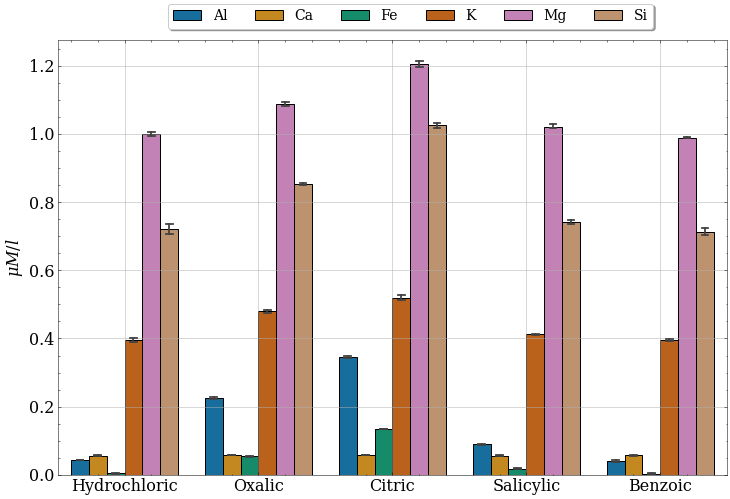

In [431]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.barplot(x='parameter', 
            y='value', 
            hue='variable', 
            data=bar_df,
            edgecolor='k',
            capsize=.05,
            dodge=True,
           ax=ax)
leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.9, 1.1),
               fontsize=14,  
               ncol=6,
               shadow=True,)

ax.grid()
ax.set_ylabel('${\mu}M/l$')

ax.set_xlabel('')
plt.savefig('../plots/barplots.png', dpi=300)
plt.show()

In [373]:
import pandas as pd
import numpy as np
import scipy.stats as stats
df=pd.read_csv('https://raw.githubusercontent.com/bilalmussa/st_sig_testing/main/test_control_data.csv')
group1 = df[df['AnalysisFlag']=='Test']['DP'].to_list()
group2 = df[df['AnalysisFlag']=='Control']['DP'].to_list()
s, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print('Statistc: ',s)
print('P Value: ',p)
#Statistc: 6966579.5
#P Value: 0.6559138409860421
#In this case, there is no significance at any conventional level

Statistc:  6966579.5
P Value:  0.6559138409860421


In [407]:
data1 = np.random.normal(loc=0, scale=1, size=1000)
data2 = np.random.normal(loc=0, scale=1, size=1000)
data3 = np.random.normal(loc=0, scale=1, size=1000)

In [423]:
from scipy.stats import mannwhitneyu, ttest_ind

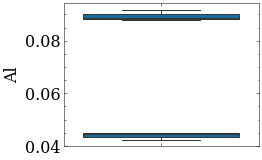

Statistics=-31.785, p=0.000
Different distribution (reject H0) Al


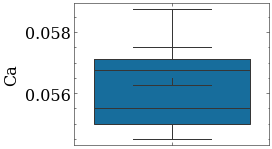

Statistics=0.437, p=0.684
Same distribution (fail to reject H0) Ca


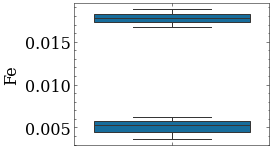

Statistics=-13.276, p=0.000
Different distribution (reject H0) Fe


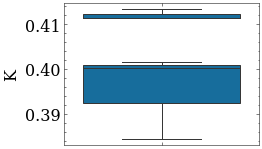

Statistics=-2.978, p=0.041
Different distribution (reject H0) K


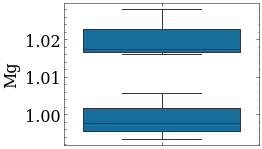

Statistics=-4.105, p=0.015
Different distribution (reject H0) Mg


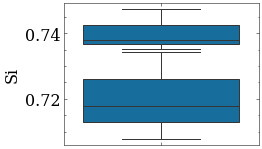

Statistics=-2.353, p=0.078
Same distribution (fail to reject H0) Si


In [430]:
for element in bar_df['variable'].unique():
    data_HCL = bar_df.loc[(bar_df['variable']==element)&(bar_df['parameter']=='Hydrochloric'), 'value']
    data_benzoic = bar_df.loc[(bar_df['variable']==element)&(bar_df['parameter']=='Salicylic'), 'value']
#     stat, p = mannwhitneyu(data_HCL, data_benzoic)
    
    stat, p = stats.ttest_ind(data_HCL, data_benzoic)
    sns.boxplot(y=data_HCL)
    sns.boxplot(y=data_benzoic)
    plt.ylabel(element)
    plt.show()
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)', element)
    else:
        print('Different distribution (reject H0)', element)

Statistics=243524.000, p=0.462
Same distribution (fail to reject H0)


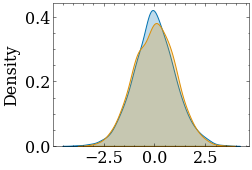

In [409]:
from scipy.stats import wilcoxon
# compare samples


stat, p = wilcoxon(data1, data2)
sns.kdeplot(x=data1, fill=True)
sns.kdeplot(x=data2, fill=True)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

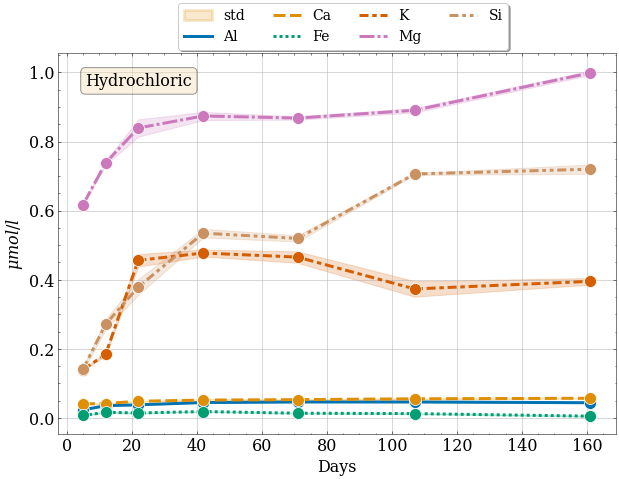

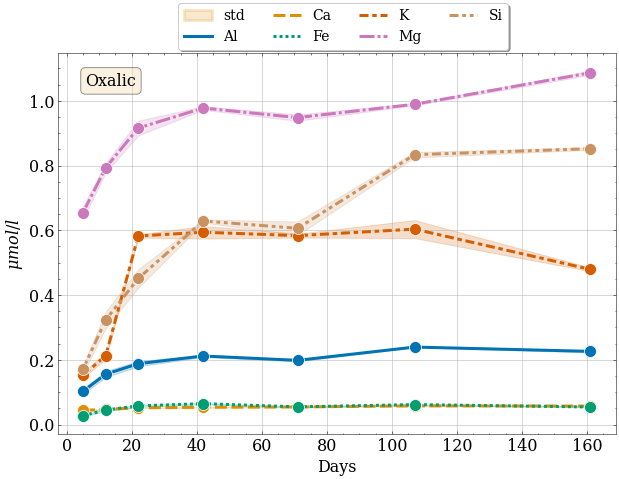

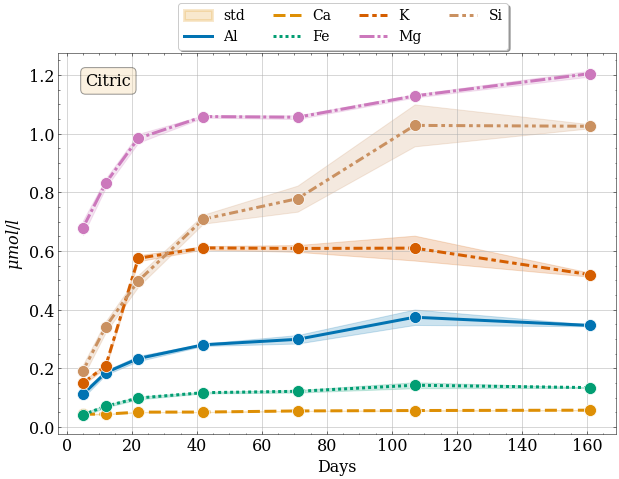

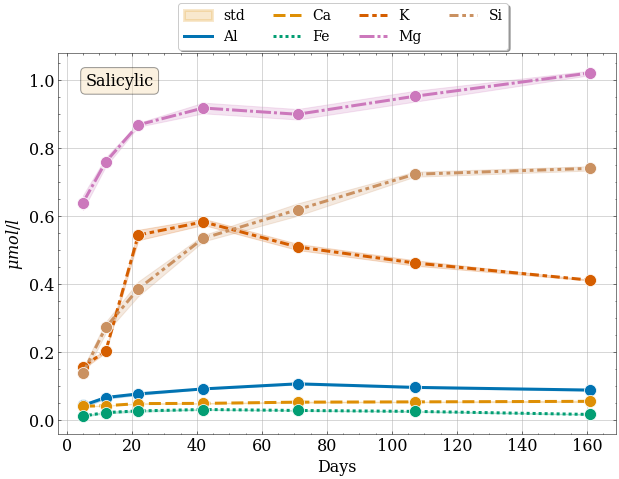

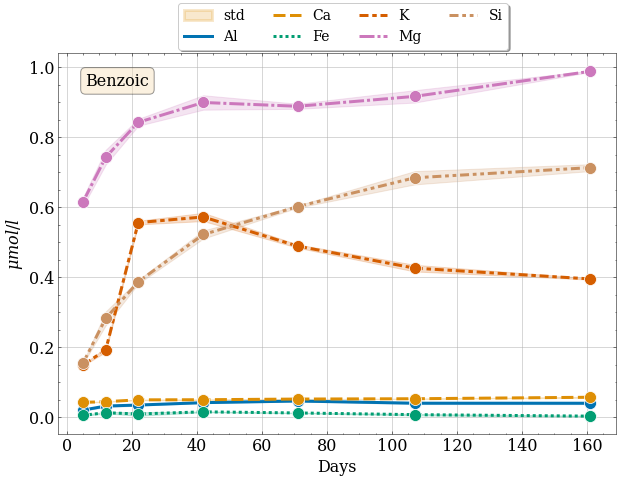

In [253]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
folder = '../plots/elements/'
acids=['Hydrochloric', 'Oxalic', 'Citric', 'Salicylic', 'Benzoic']
for i, acid in enumerate(acids):
    mask = df_melted['parameter']==acid
    
    acid_df = df_melted.loc[mask]
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y='value',
                 marker='o',
                 markersize=12, 
                 data=acid_df, 
                 ci='sd',
#                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'variable', 
                 linewidth = 3,
                 hue='variable',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('std')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.82, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)
    
    ax.set_ylabel('${\mu}mol/l$')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(3)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    ax.text(0.05, 0.95, acid, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    fname = os.path.join(folder, acid+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [296]:
df_ph = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ph_ds')

dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['code', 'days', 'pH', 'RedOx', 'EC']
df_ph = df_ph[cols]

In [297]:
df_ph=df_ph.merge(df[['parameter', 'code']], on='code', how='left')

In [298]:
mask = df_ph['parameter'].isna()
sel = df_ph.loc[mask].index

In [299]:
df_ph = df_ph.fillna(method='bfill')

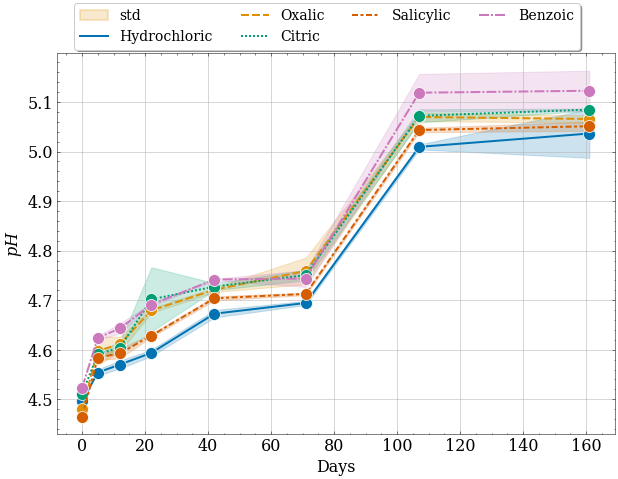

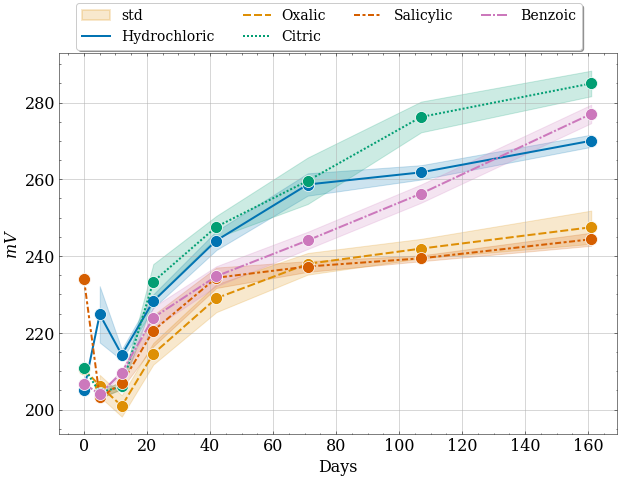

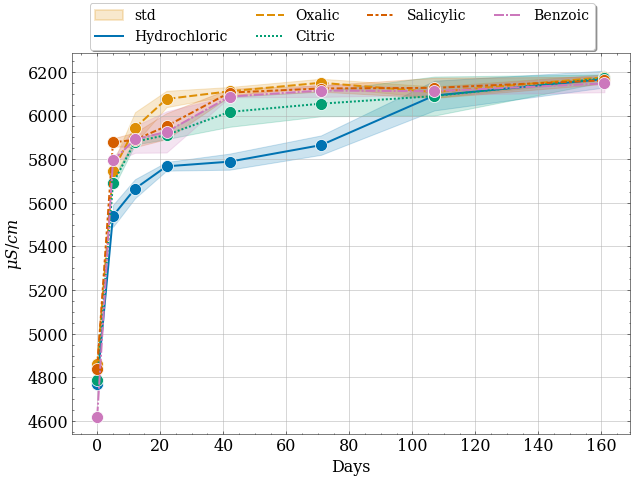

In [303]:
folder = '../plots/phys_chem/'
units = {'pH':'$pH$', 
         "RedOx": "$mV$", 
         'EC': "${\mu}S/cm$" }
for prp in ['pH', "RedOx", 'EC']:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=prp,
                 marker='o',
                 markersize=12, 
                 data=df_ph, 
                 ci='sd',
    #                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'parameter', 
                 linewidth = 2,
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('std')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.95, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)

    ax.set_ylabel(units[prp])
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(2)

    fname = os.path.join(folder, prp+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()


### End

In [434]:
fname = '/Users/mikhailgasanov/Documents/GIT/CLASS_DAP_Classifier/app/core_csm/CLASS_DAP_DB/CCE/all_CCE.csv'
df_cce = pd.read_csv(fname)

In [437]:
mask = df_cce['district']=='Karnal'

In [446]:
df_cce['day_sowing'] = pd.to_datetime(df_cce['day_sowing'])
start = df_cce.loc[mask, 'day_sowing'].mean().date()
print('Start season', start)

df_cce['day_cce'] = pd.to_datetime(df_cce['day_cce'])
end = df_cce.loc[mask, 'day_cce'].mean().date()
print('End season', end)





Start season 2020-11-12
End season 2021-04-15


In [455]:
df = pd.read_csv('/Users/mikhailgasanov/Downloads/ForestHealh.csv')

In [456]:
df

,Unnamed: 0,id,year,defoliation,x,y,age,canopy,inclination,elevation,soil,ph,moisture,alkali,humus,stand,fertilized
0,1,5,1983,"[0, 12.5)",1.5,5.0,43,1.0,2,320,10,4.610,moderately dry,high,"(1cm, 2cm]",mixed,yes
1,2,5,1984,"[0, 12.5)",1.5,5.0,44,1.0,2,320,10,4.340,moderately dry,high,"(3cm, 4cm]",mixed,yes
2,3,5,1985,"[0, 12.5)",1.5,5.0,45,1.0,2,320,10,4.750,moderately dry,high,"[0cm, 1cm]",mixed,yes
3,4,5,1986,"[0, 12.5)",1.5,5.0,46,1.0,2,320,10,3.990,moderately dry,high,"(2cm, 3cm]",mixed,yes
4,5,5,1987,"[0, 12.5)",1.5,5.0,47,1.0,2,320,10,5.300,moderately dry,high,"[0cm, 1cm]",mixed,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,1791,82,1999,"[0, 12.5)",16.1,2.0,81,0.7,26,280,50,4.350,moist or temporarily wet,low,"[0cm, 1cm]",mixed,no
1789,1792,82,2000,"[0, 12.5)",16.1,2.0,82,0.7,26,280,50,4.305,moist or temporarily wet,low,"[0cm, 1cm]",mixed,no
1790,1793,82,2001,"[0, 12.5)",16.1,2.0,83,0.8,26,280,50,4.260,moist or temporarily wet,low,"[0cm, 1cm]",mixed,no
1791,1794,82,2002,"[0, 12.5)",16.1,2.0,84,0.7,26,280,50,4.410,moist or temporarily wet,low,"[0cm, 1cm]",mixed,no


https://zenodo.org/record/5018102

In [450]:
df = pd.read_excel('/Users/mikhailgasanov/Downloads/dryad_data.xlsx')

In [453]:
df

,ID,X_coord,Y_coord,PopDen1900,PopDen1910,PopDen1920,PopDen1930,PopDen1940,PopDen1950,PopDen1960,...,WM_pres,WPBR_pres,WS_pres,CRS_pres,EBB_pres,GOS_pres,CCS_pres,SBS_pres,SJS_pres,PTB_pres
0,8556,5.216798e+04,1.017314e+06,2.603602,3.682887,4.367696,4.103006,4.701486,4.402684,4.167919,...,0.0,0.763940,0.0,0.0,0.0,0.000000,0.0,0.100762,1,0.000000
1,8557,1.021680e+05,1.017314e+06,0.595222,1.390414,2.190611,2.102913,2.644163,2.526317,2.477333,...,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1,0.000000
2,8728,5.216798e+04,1.067314e+06,1.741888,2.428481,3.090501,2.816350,3.385771,3.127428,2.796808,...,0.0,0.781668,0.0,0.0,0.0,0.000000,0.0,0.000000,1,0.000000
3,8729,1.021680e+05,1.067314e+06,0.000000,0.561896,1.181284,1.596187,2.000862,1.910066,1.965069,...,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1,0.000000
4,8900,5.216798e+04,1.117314e+06,0.869384,1.409361,1.653868,2.090183,2.620095,2.418969,2.045807,...,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,6336,8.521680e+05,3.673136e+05,25.905006,28.912235,31.132174,36.608674,39.115102,46.654201,59.776135,...,0.0,1.000000,0.0,0.0,0.0,0.727029,0.0,0.000000,1,0.727029
3368,6335,8.021680e+05,3.673136e+05,32.856050,38.328511,43.323749,56.712180,59.423001,73.493628,90.381851,...,0.0,1.000000,0.0,0.0,0.0,0.532223,0.0,0.000000,1,0.532223
3369,6688,1.252168e+06,4.673136e+05,52.436992,61.512942,81.758106,93.335215,96.323612,116.824376,133.488469,...,0.0,1.000000,1.0,0.0,1.0,1.000000,0.0,0.000000,1,1.000000
3370,6689,1.302168e+06,4.673136e+05,52.436992,61.512942,81.758106,93.335215,96.323612,116.824376,133.488469,...,0.0,1.000000,1.0,0.0,1.0,1.000000,0.0,0.000000,1,1.000000
